<a href="https://colab.research.google.com/github/mgfalzon/Final-Tutorial/blob/main/Matt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![title](https://github.com/mgfalzon/Final-Tutorial/blob/main/all_pokemons.png?raw=1)

### **Predicting Pokemon Battle Outcomes Through Stats**

Matthew Falzon, Robert Calkins, Michael Bailey

#### **Introduction**

*introduction in progress*

<p>
Pokémon is a video game franchise centered around fictional creatures called 'Pokémon' which humans catch, train, and battle for sport. In the game, the player is tasked with building a team of strong Pokémon which they will use in to challenge other 'Pokemon Trainers'. Most games follow a linear progression in which the player travels from town to town battling powerful trainers known as 'Gym Leaders' that the trainer must defeat in order to collect a gym badge. Once all badges have been collected the player can progress to the Elite Four, four of the most powerful pokemon trainers in the reigion, which the player can battle in succession in order to reach the Regional champion who they can battle in order to become the new champion.
</p>

<br/>
<p>
<em>talk about the battle system</em>
</p>
<br/>


<p>
This tutorial seeks to explore the relationship between a pokemon's characteristics and win percentage in 100 simulated battles. In order to preform our analysis we'll be looking at 3 characterstics, a pokemon's type, their base stats, and finally their legendary status. We want to know if we can use these characterstics in order to predict the outcome of future battles. The Kaggle dataset <a href="https://www.kaggle.com/terminus7/pokemon-challenge">Pokemon- Weedle's Cave</a> by user terminus7 contains two files which will be used to preform our analysis. The first file contains the pokemon charactersitics and the second one contains information about previous battles.
</p>

#### **Python Libraries**

In [187]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

#### **Importing Data**

In [115]:
path = "https://raw.githubusercontent.com/mgfalzon/Final-Tutorial/main"
combats = pd.read_csv(f"{path}/combats.csv")
pokemon = pd.read_csv(f"{path}/pokemon.csv")
tests = pd.read_csv(f"{path}/tests.csv")
display("Pokemon", pokemon.head())
display("Combats", combats.head())

'Pokemon'

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


'Combats'

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


#### **Tidy Data**

In [116]:
# Find missing data
pokemon.isna().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [329]:
combats.isna().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
Loser             0
dtype: int64

<sub>*Note: type 2 is missing because some pokemon only have one type</sub>

In [117]:
# One pokemon is missing from the data
missing = pokemon[pokemon['Name'].isna()]
missing

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


In [118]:
# Take a look at the surrounding pokemon
miss_id = missing.index[0]
pokemon[miss_id - 3 : miss_id + 3]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
59,60,Psyduck,Water,NaN,50,52,48,65,50,55,1,False
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False


In [119]:
# Use the pokeAPI in order to find the missing pokemon
def pokeAPI(s):
    r = requests.get(f"https://pokeapi.co/api/v2/pokemon/{s}")
    return json.loads(r.content)

In [120]:
# Check the pokemon after Mankey in the pokeAPI
res = pokeAPI('mankey')
res = pokeAPI(res['id'] + 1)
display(res['name'], res['types'], res['stats'])

'primeape'

[{'slot': 1,
  'type': {'name': 'fighting', 'url': 'https://pokeapi.co/api/v2/type/2/'}}]

[{'base_stat': 65,
  'effort': 0,
  'stat': {'name': 'hp', 'url': 'https://pokeapi.co/api/v2/stat/1/'}},
 {'base_stat': 105,
  'effort': 2,
  'stat': {'name': 'attack', 'url': 'https://pokeapi.co/api/v2/stat/2/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'defense', 'url': 'https://pokeapi.co/api/v2/stat/3/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'special-attack',
   'url': 'https://pokeapi.co/api/v2/stat/4/'}},
 {'base_stat': 70,
  'effort': 0,
  'stat': {'name': 'special-defense',
   'url': 'https://pokeapi.co/api/v2/stat/5/'}},
 {'base_stat': 95,
  'effort': 0,
  'stat': {'name': 'speed', 'url': 'https://pokeapi.co/api/v2/stat/6/'}}]

In [121]:
# Clean stats for readability
data = {stat['stat']['name'] : stat['base_stat'] for stat in res['stats']}
data['type'] = res['types'][0]['type']['name']
df = pd.DataFrame(data, [res['name']])
display("pokeAPI Data", df)
display("Our Data", missing.iloc[:,1:10])

'pokeAPI Data'

,hp,attack,defense,special-attack,special-defense,speed,type
primeape,65,105,60,60,70,95,fighting


'Our Data'

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
62,NaN,Fighting,NaN,65,105,60,60,70,95


It's a match!

In [122]:
# Update the data
pokemon['Name'] = np.where(pokemon['Name'].isna(), 'Primeape', pokemon['Name'])
pokemon[miss_id - 3 : miss_id + 3]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
59,60,Psyduck,Water,NaN,50,52,48,65,50,55,1,False
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False


#### **Data Exploration**

In [246]:
# Insert Loser column
combats['Loser'] = pd.Series(np.where(combats['Winner'] == combats['First_pokemon'], combats['Second_pokemon'], combats['First_pokemon']))
combats.head(3)

First_pokemon     0
Second_pokemon    0
Winner            0
Loser             0
dtype: int64

In [324]:
# Generate win-loss percentages
wins = combats['Winner'].value_counts().sort_index().rename('Wins')
loss = combats['Loser'].value_counts().sort_index().rename('Loss')
res = pd.concat([wins, loss], axis=1)
res['win_loss'] = res['Wins'] / (res['Wins'] + res['Loss'])
res['win_pct']  = (res['win_loss'] * 100).round(1)
res.head()

,First_pokemon,Second_pokemon,Winner,Loser


In [125]:
# Join with pokemon table
pokemon = pokemon.join(res, on='#')

In [126]:
# Top 50 Pokemon by win percentage
top50 = pokemon.sort_values(by='win_pct', ascending=False).head(50)
top50[['Name', 'win_pct']].head()

,Name,win_pct
154,Mega Aerodactyl,98.4
512,Weavile,97.5
703,Tornadus Therian Forme,96.8
19,Mega Beedrill,96.6
153,Aerodactyl,96.5


In [127]:
# Bottom 50 Pokemon by win percentage
bot50 = pokemon.sort_values(by='win_pct', ascending=True).head(50)
bot50[['Name', 'win_pct']].head()

,Name,win_pct
289,Silcoon,2.2
189,Togepi,2.5
638,Solosis,3.1
236,Slugma,3.3
576,Munna,3.9


In [128]:
# Remove Mega Pokemon
pokemon = pokemon[pokemon['Name'].str.match(r'Mega .*') == False]

# Recalculate top and bottom 50
top50 = pokemon.sort_values(by='win_pct', ascending=False).head(50)
bot50 = pokemon.sort_values(by='win_pct', ascending=True).head(50)

pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Loss,win_loss,win_pct
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,96.0,0.278195,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,75.0,0.380165,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,43.0,0.674242,67.4
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55.0,57.0,0.491071,49.1
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64.0,54.0,0.542373,54.2


In [129]:
# Non-Mega pokemon with most wins
top50[['Name', 'win_pct']].head()

,Name,win_pct
512,Weavile,97.5
703,Tornadus Therian Forme,96.8
153,Aerodactyl,96.5
726,Greninja,96.1
716,Meloetta Pirouette Forme,95.9


In [130]:
# Type frequency
type_freq = pokemon.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('freq')
type_freq = type_freq.sort_values(ascending=False)
pd.DataFrame(type_freq).head()

,,freq
Type 1,Type 2,
Normal,NaN,60
Water,NaN,58
Psychic,NaN,36
Grass,NaN,33
Fire,NaN,28


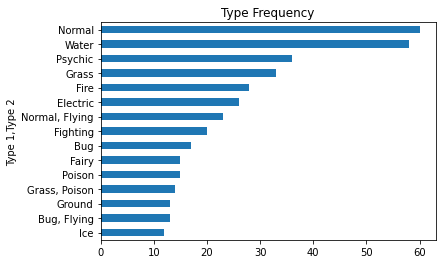

In [131]:
# Graph type frequency
ax = type_freq.head(15).plot.barh()
ax.set_title("Type Frequency")
yticks = [t1 if pd.isna(t2) else f'{t1}, {t2}' for (t1,t2) in type_freq.index]
ax.set_yticklabels(yticks)
ax.invert_yaxis()

In [132]:
# Top 50 pokemon Type frequency
type_freq = top50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Normal,NaN,5
1,Electric,NaN,5
2,Psychic,NaN,5
3,Dark,NaN,3
4,Water,NaN,2


In [133]:
# Bottom 50 pokemon Type frequency
type_freq = bot50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Bug,NaN,8
1,Psychic,NaN,7
2,Grass,NaN,4
3,Normal,NaN,4
4,Normal,Fairy,3


In [134]:
# Split data by generation
gen = {g:df for g, df in pokemon.groupby(by='Generation')}
gen[1].head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Loss,win_loss,win_pct
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,96.0,0.278195,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,75.0,0.380165,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,43.0,0.674242,67.4
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55.0,57.0,0.491071,49.1
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64.0,54.0,0.542373,54.2


In [328]:
# Fuck me there's an error
pokemon.isna().sum()

#               0
Name            0
Type 1          0
Type 2        377
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
Wins           16
Loss           15
win_loss       16
win_pct        16
dtype: int64

#### **Data Visualization**

16

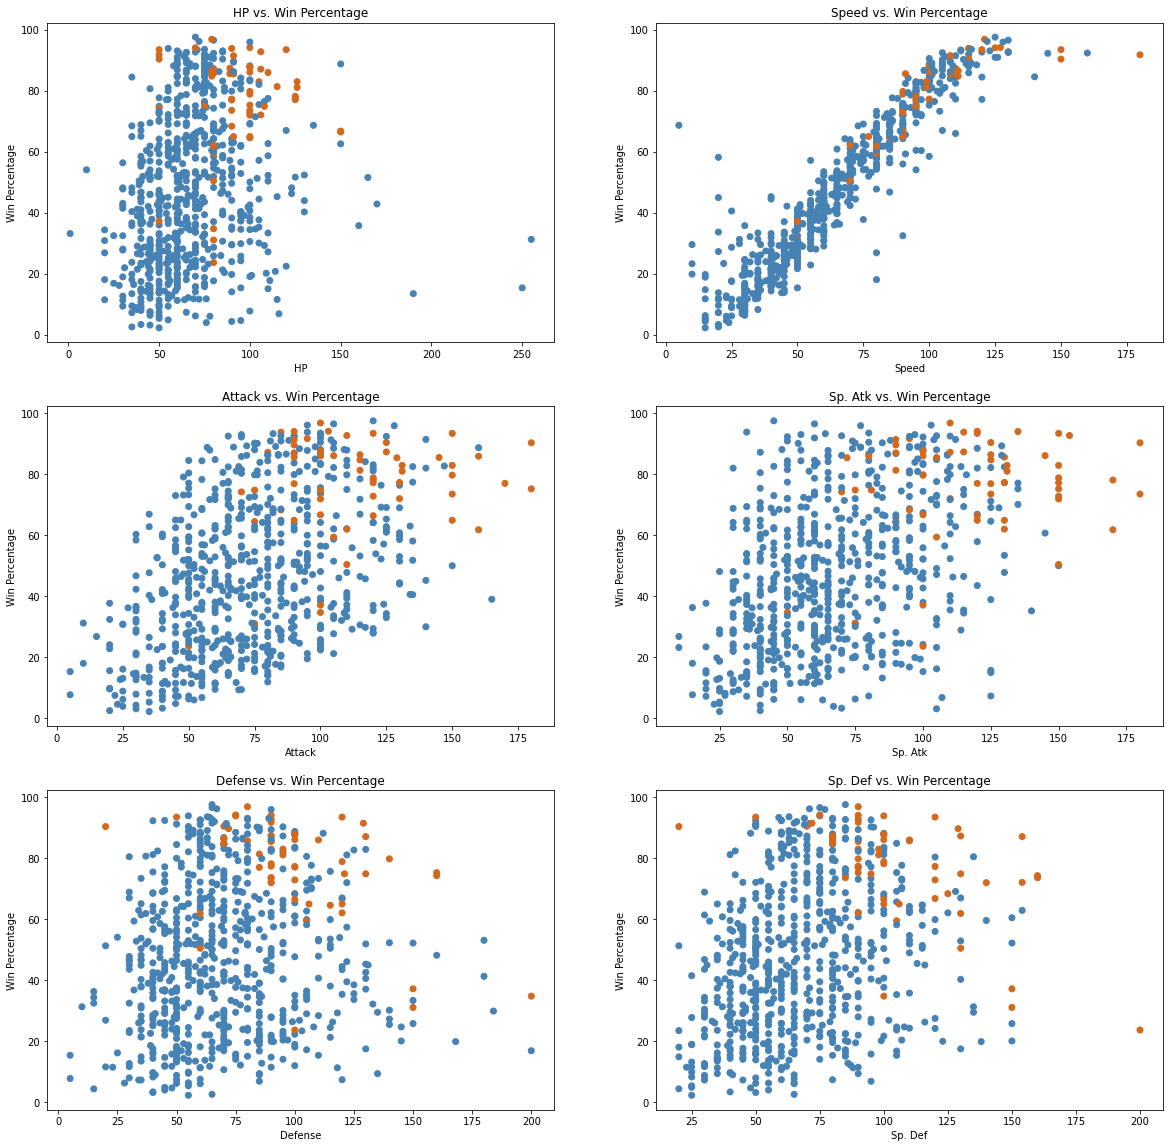

In [326]:
# Graph Base Stats -- Win Percentage
base_stats = ["HP", "Speed", "Attack", "Sp. Atk", "Defense", "Sp. Def"]
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
pts = [(i, j) for i in range(3) for j in range(2)]

color = np.where(pokemon['Legendary'] == True, 'chocolate', 'steelblue')
for stat, (x,y) in zip(base_stats, pts):
  # Plot stat on subplot
  ax = axs[x, y]
  ax.scatter(stat, "win_pct", data=pokemon, c=color)
  ax.set(title=f'{stat} vs. Win Percentage', xlabel=stat, ylabel='Win Percentage')

  # Line of best fit
  x, y = pokemon[stat], pokemon['win_pct']
  m,b = np.polyfit(x, y, 1)
  plt.plot(x, x*m + b)

#### **Analysis**